Image 0: Min=0.1411764770746231, Max=0.9803921580314636, Dtype=float32


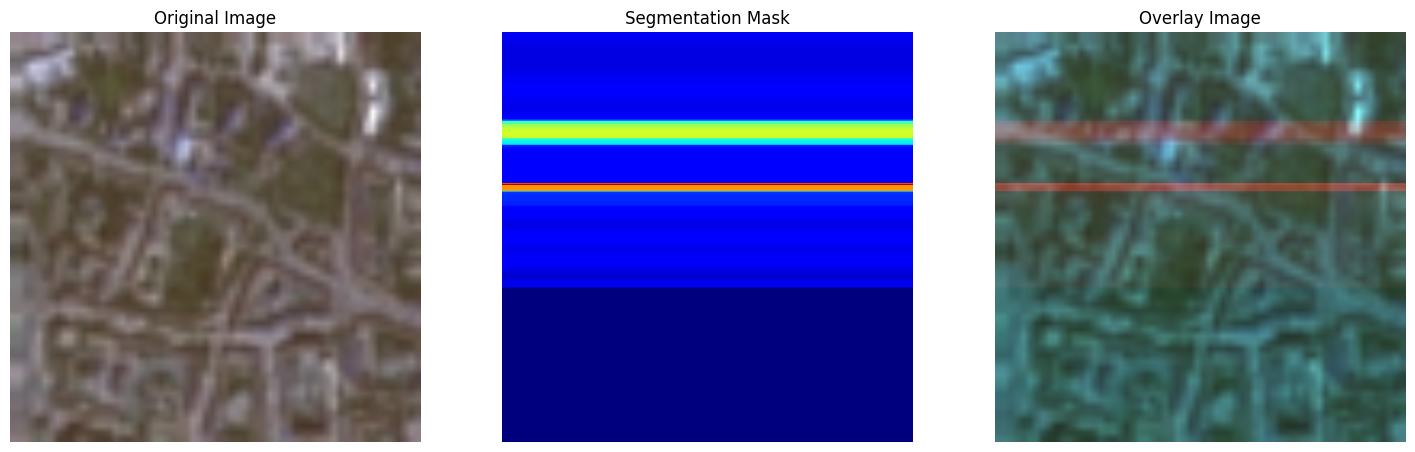

Image 1: Min=0.16078431904315948, Max=0.9882352948188782, Dtype=float32


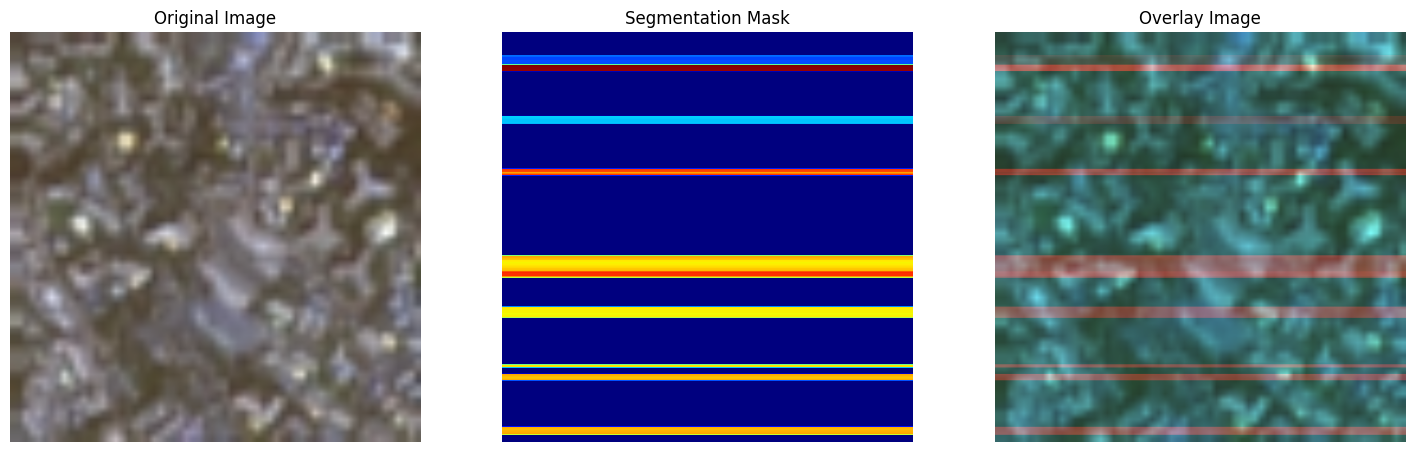

Image 2: Min=0.18431372940540314, Max=1.0, Dtype=float32


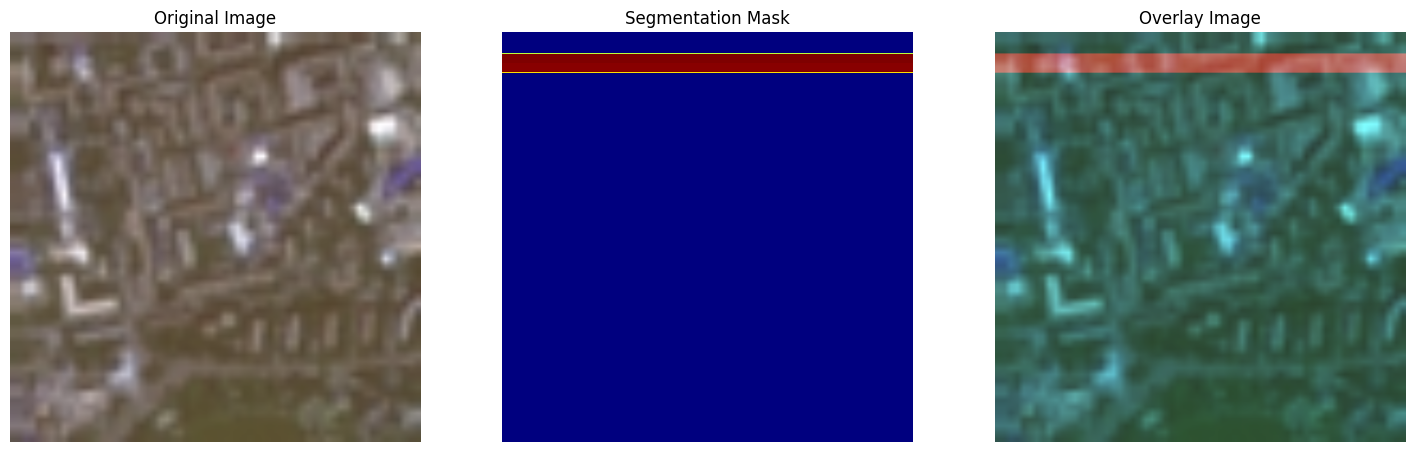

Image 3: Min=0.16078431904315948, Max=0.8117647171020508, Dtype=float32


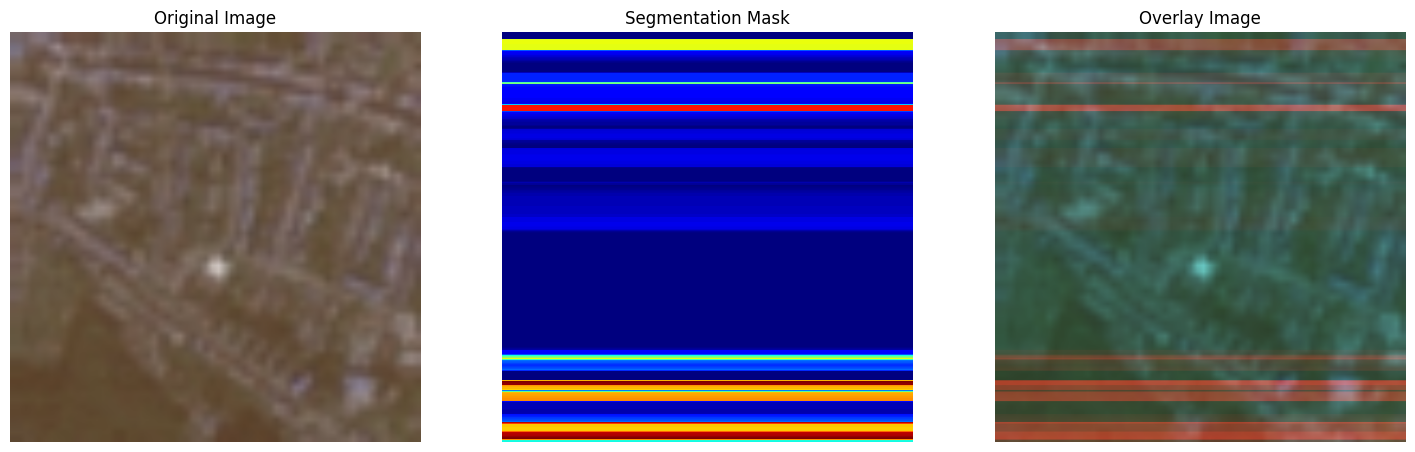

Image 4: Min=0.13333334028720856, Max=0.8745098114013672, Dtype=float32


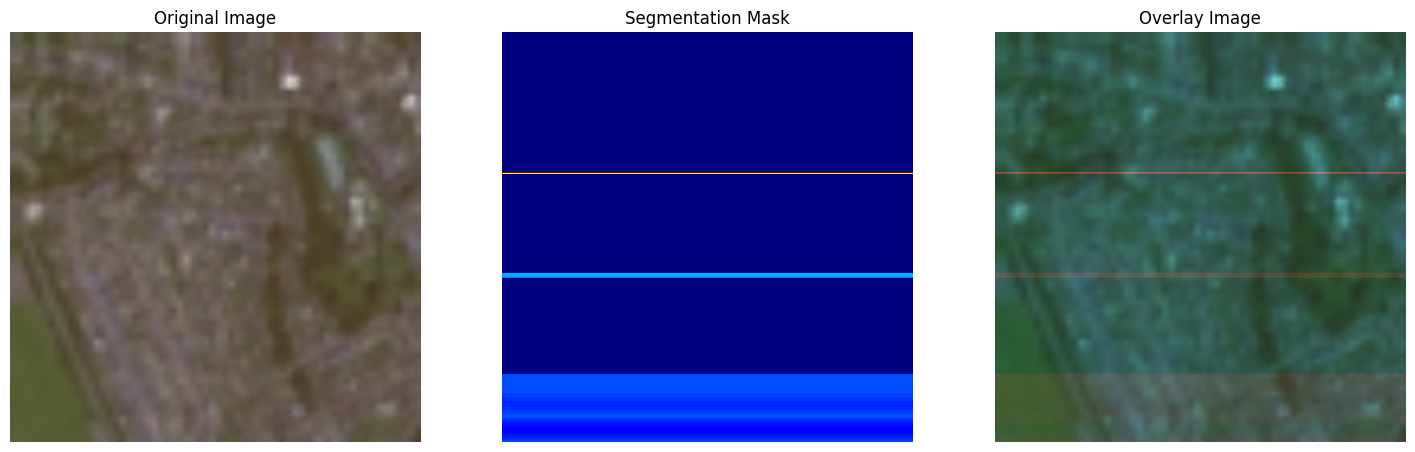

Image 5: Min=0.18039216101169586, Max=1.0, Dtype=float32


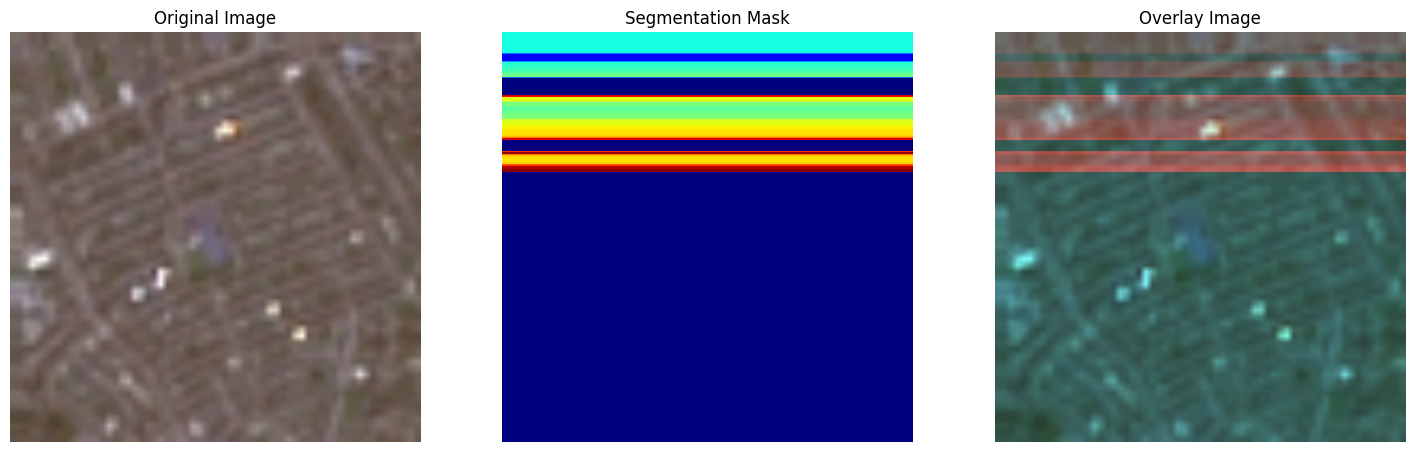

Image 6: Min=0.1568627506494522, Max=0.8313725590705872, Dtype=float32


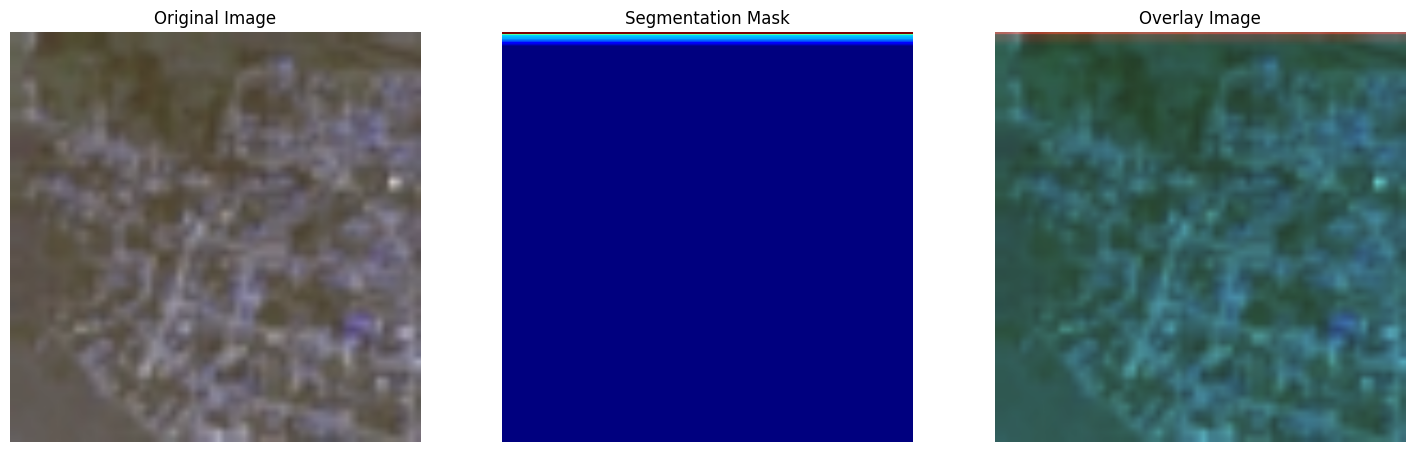

Image 7: Min=0.1411764770746231, Max=0.9686274528503418, Dtype=float32


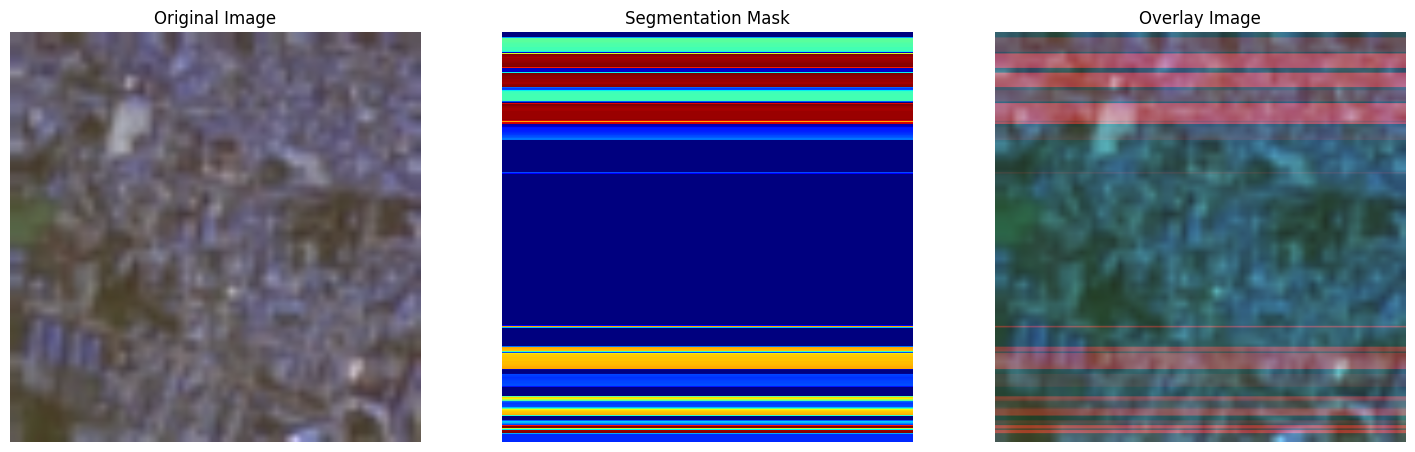

Image 8: Min=0.0470588244497776, Max=1.0, Dtype=float32


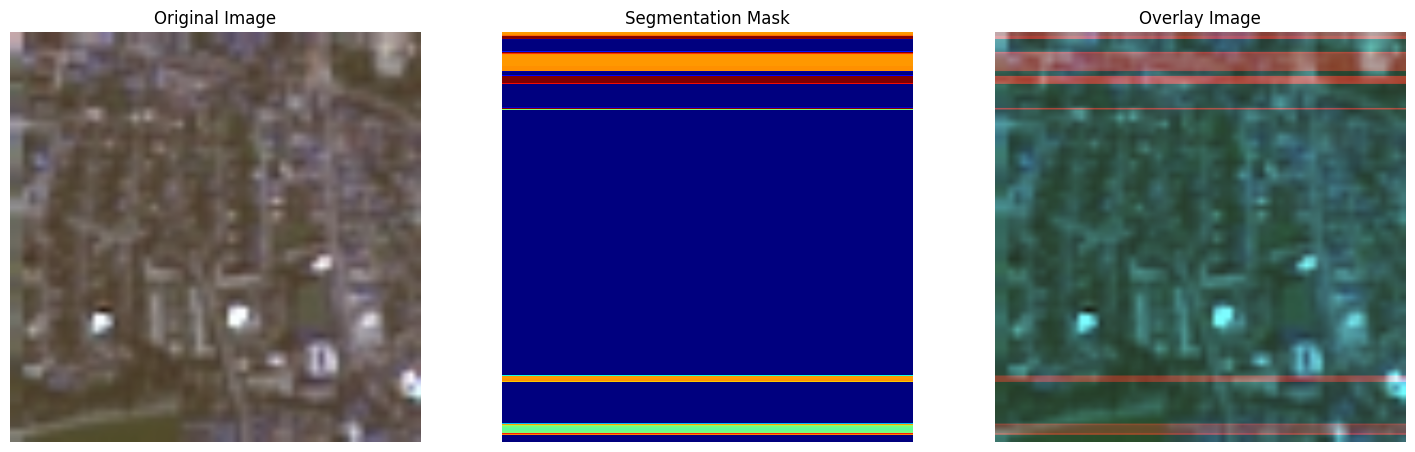

Image 9: Min=0.15294118225574493, Max=0.7529411911964417, Dtype=float32


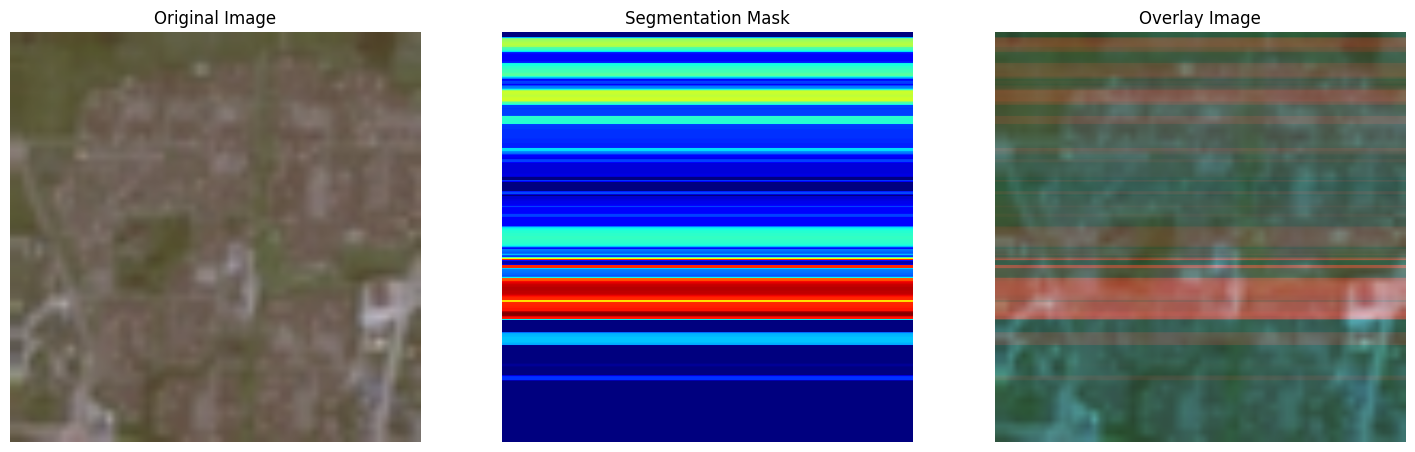

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Paths
category = "Residential"
split = "test"
training_data_dir = f"../data/training_data/{split}"
output_masks_dir = f"../data/single_channel_masks/{category}/{split}"

# Number of test images to visualize
num_test_images = 10

# Load images
image_path = os.path.join(training_data_dir, f"{category}_{split}.npy")
images = np.load(image_path)

# List all mask batches
batch_files = sorted([os.path.join(output_masks_dir, f) for f in os.listdir(output_masks_dir) if f.startswith("batch_")])

# Batch size
batch_size = 20  # Adjust if different from your script

for i in range(num_test_images):
    # Original image
    original_image = images[i]

    # Debug original image values
    print(f"Image {i}: Min={original_image.min()}, Max={original_image.max()}, Dtype={original_image.dtype}")

    # Convert original image to uint8 for proper visualization
    if original_image.max() <= 1.0:  # Normalized range [0, 1]
        original_image = (original_image * 255).astype(np.uint8)
    elif original_image.dtype != np.uint8:  # Convert other ranges to uint8
        original_image = original_image.astype(np.uint8)

    # Determine which batch contains the mask
    batch_index = i // batch_size
    mask_index = i % batch_size

    # Load the corresponding mask batch
    if batch_index >= len(batch_files):
        print(f"No batch available for image {i}. Skipping.")
        continue

    mask_batch_path = batch_files[batch_index]
    mask_batch = np.load(mask_batch_path)

    # Extract the specific mask
    segmentation_mask = mask_batch[mask_index]

    # Select the most likely class for each pixel (single-channel)
    segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)

    # Resize segmentation mask to match the original image dimensions
    segmentation_mask_resized = cv2.resize(
        segmentation_mask_class.astype(np.uint8),
        (original_image.shape[1], original_image.shape[0]),
        interpolation=cv2.INTER_NEAREST,
    )

    # Normalize segmentation mask for overlay
    segmentation_mask_normalized = segmentation_mask_resized / segmentation_mask_resized.max()

    # Overlay segmentation mask on the original image
    overlay_image = original_image.copy()
    overlay_image[..., 0] = (
        overlay_image[..., 0] * 0.5 + segmentation_mask_normalized * 255 * 0.5
    )

    # Visualization
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask_resized, cmap="jet")
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_image)
    plt.title("Overlay Image")
    plt.axis("off")

    plt.show()


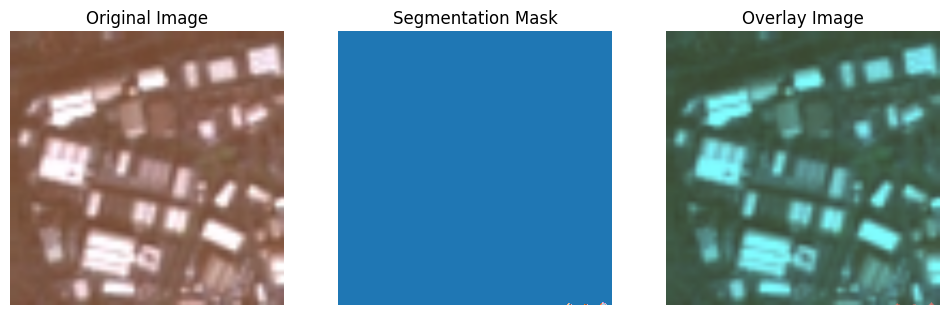

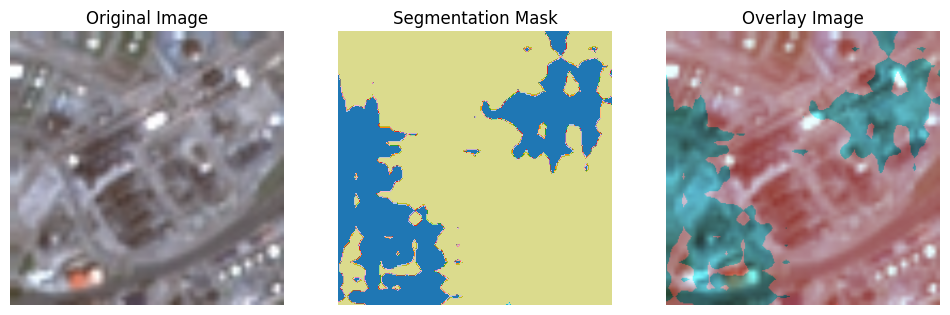

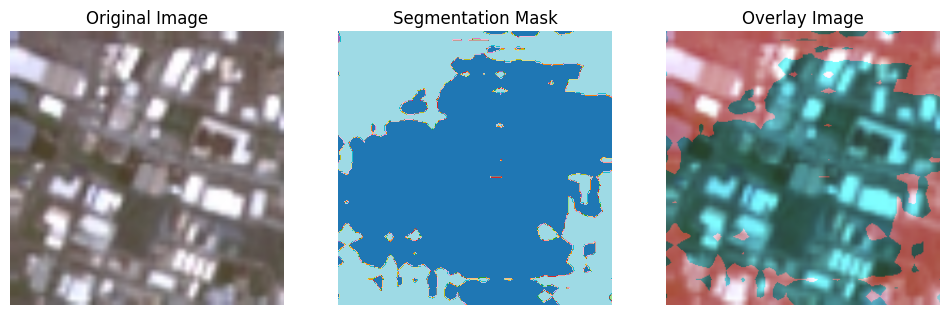

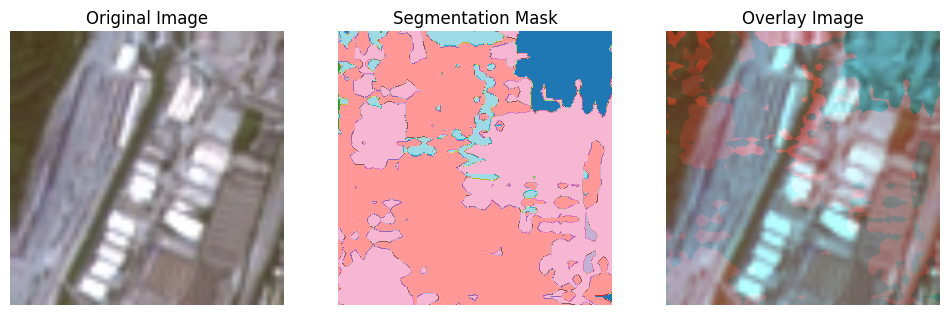

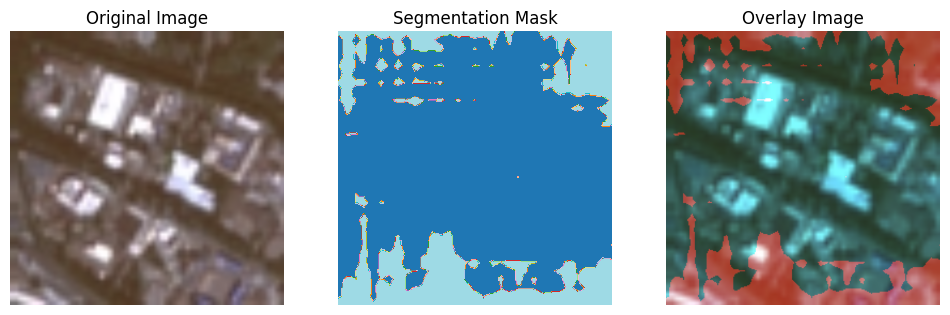

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Ensure OpenCV is installed: pip install opencv-python

# Paths
category = "Industrial"  # Change as needed
split = "train"          # Options: train, val, test
preprocessed_outdir = "../data/preprocessed_output_data"
output_masks_dir = f"../data/segmentation_masks/{category}/{split}"

# Load images and masks
image_path = os.path.join(preprocessed_outdir, f"{category}_{split}.npy")
images = np.load(image_path)

# Configuration
alpha = 0.5  # Transparency for overlay
use_colormap = False  # Toggle between grayscale and color map overlay

for i in range(5):  # Visualize the first 5 images
    # Original image
    original_image = images[i]

    # Normalize the original image to uint8 for visualization
    if original_image.max() <= 1.0:  # Normalized range [0, 1]
        original_image = (original_image * 255).astype(np.uint8)
    elif original_image.dtype != np.uint8:  # Other ranges
        original_image = original_image.astype(np.uint8)

    # Load segmentation mask
    mask_path = os.path.join(output_masks_dir, f"mask_{i}.npy")
    if not os.path.exists(mask_path):
        print(f"Mask not found for image {i}. Skipping.")
        continue
    segmentation_mask = np.load(mask_path)

    # Convert multi-class segmentation mask to single-channel
    segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)

    # Resize segmentation mask to match the original image dimensions
    segmentation_mask_resized = cv2.resize(
        segmentation_mask_class.astype(np.uint8),
        (original_image.shape[1], original_image.shape[0]),
        interpolation=cv2.INTER_NEAREST,
    )

    # Create overlay
    if use_colormap:
        # Overlay using a color map
        overlay_image = cv2.addWeighted(
            original_image, alpha,
            cv2.applyColorMap((segmentation_mask_resized * (255 / segmentation_mask_resized.max())).astype(np.uint8), cv2.COLORMAP_JET),
            1 - alpha,
            0
        )
    else:
        # Overlay using grayscale normalization
        segmentation_mask_normalized = segmentation_mask_resized / segmentation_mask_resized.max()
        overlay_image = original_image.copy()
        overlay_image[..., 0] = (
            overlay_image[..., 0] * (1 - alpha) + segmentation_mask_normalized * 255 * alpha
        )

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask_resized, cmap="tab20")
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_image)
    plt.title("Overlay Image")
    plt.axis("off")
    plt.show()


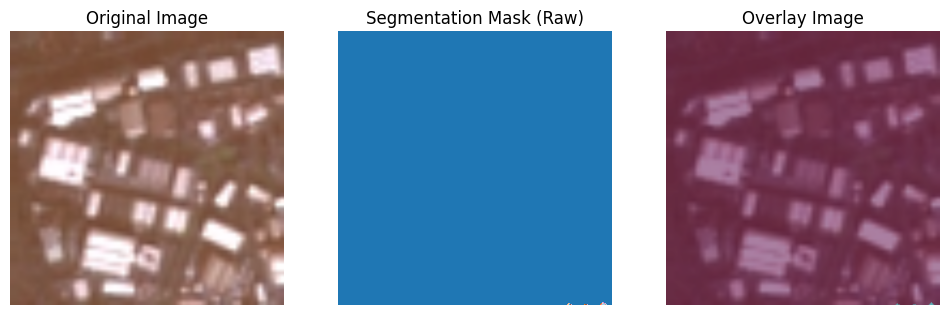

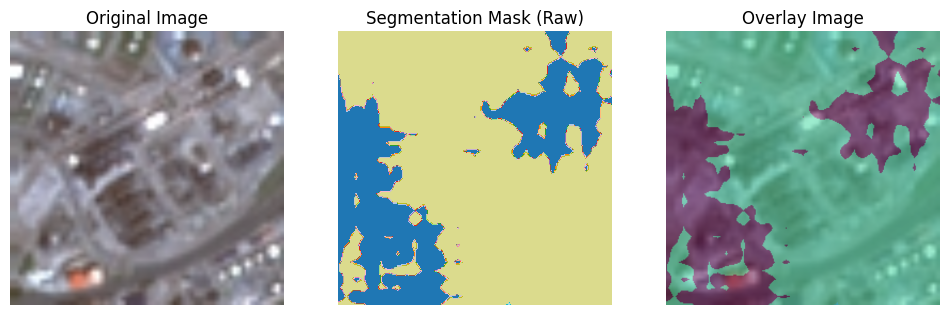

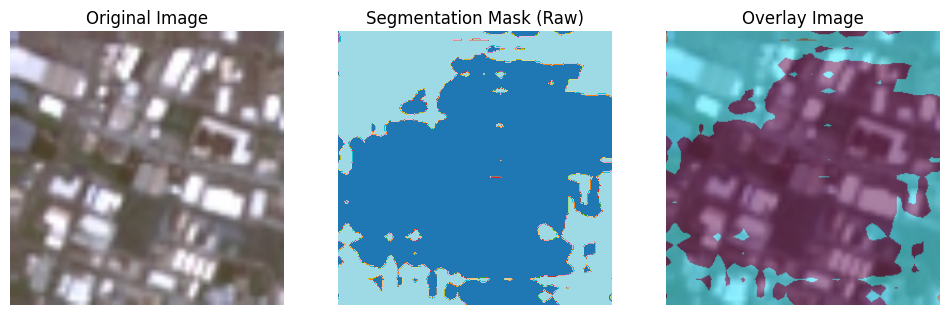

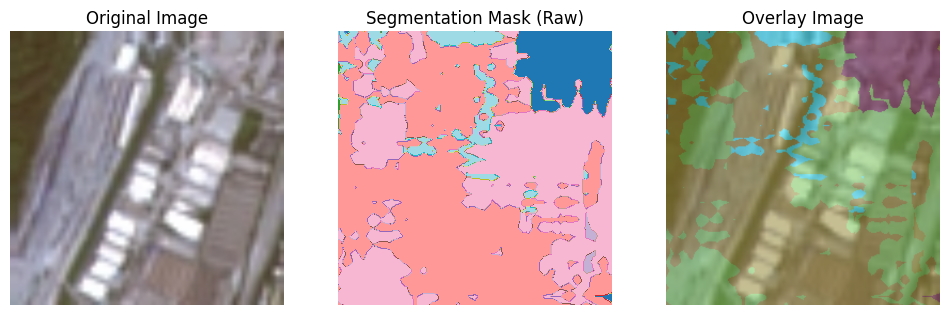

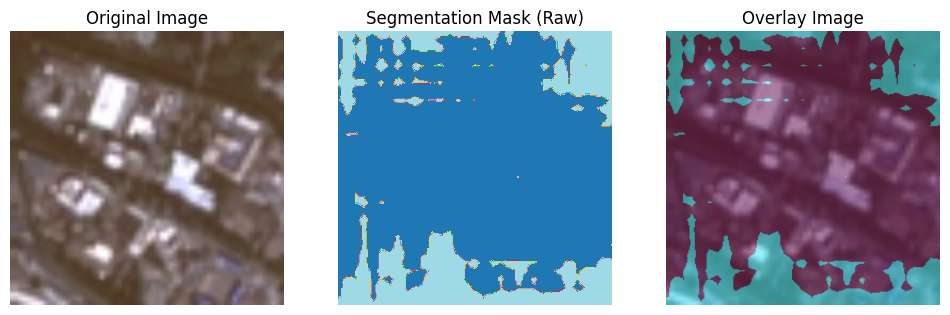

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Ensure OpenCV is installed: pip install opencv-python

# Paths
category = "Industrial"  # Change as needed
split = "train"          # Options: train, val, test
preprocessed_outdir = "../data/preprocessed_output_data"
output_masks_dir = f"../data/segmentation_masks/{category}/{split}"

# Load images and masks
image_path = os.path.join(preprocessed_outdir, f"{category}_{split}.npy")
images = np.load(image_path)

# Configuration
alpha = 0.5  # Transparency for overlay
color_map = cv2.COLORMAP_VIRIDIS  # Smoother color map

for i in range(5):  # Visualize the first 5 images
    # Original image
    original_image = images[i]

    # Normalize the original image to uint8 for visualization
    if original_image.max() <= 1.0:
        original_image = (original_image * 255).astype(np.uint8)
    elif original_image.dtype != np.uint8:
        original_image = original_image.astype(np.uint8)

    # Load segmentation mask
    mask_path = os.path.join(output_masks_dir, f"mask_{i}.npy")
    if not os.path.exists(mask_path):
        print(f"Mask not found for image {i}. Skipping.")
        continue
    segmentation_mask = np.load(mask_path)

    # Convert multi-class segmentation mask to single-channel
    segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)

    # Resize and normalize the segmentation mask
    segmentation_mask_resized = cv2.resize(
        segmentation_mask_class.astype(np.uint8),
        (original_image.shape[1], original_image.shape[0]),
        interpolation=cv2.INTER_NEAREST,
    )
    segmentation_mask_resized_normalized = (segmentation_mask_resized / segmentation_mask_resized.max()) * 255
    segmentation_mask_resized_normalized = segmentation_mask_resized_normalized.astype(np.uint8)

    # Apply color map
    color_mapped_mask = cv2.applyColorMap(segmentation_mask_resized_normalized, color_map)

    # Create overlay
    overlay_image = cv2.addWeighted(original_image, alpha, color_mapped_mask, 1 - alpha, 0)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask_resized, cmap="tab20")
    plt.title("Segmentation Mask (Raw)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_image)
    plt.title("Overlay Image")
    plt.axis("off")
    plt.show()


In [33]:
# 1. Entropy (Measure of Class Diversity)

import os
import numpy as np
from scipy.stats import entropy

# Paths
output_masks_dir = "../data/segmentation_masks"

# Function to calculate entropy for a single mask
def calculate_entropy(segmentation_mask_class):
    unique, counts = np.unique(segmentation_mask_class, return_counts=True)
    class_probabilities = counts / np.sum(counts)
    return entropy(class_probabilities)

# Function to process all categories and splits
def calculate_entropy_for_all_masks(output_masks_dir):
    results = {}

    for category in os.listdir(output_masks_dir):  # Iterate over categories
        category_path = os.path.join(output_masks_dir, category)
        if not os.path.isdir(category_path):
            continue
        
        category_results = {}
        for split in ["train", "val", "test"]:  # Iterate over splits
            split_path = os.path.join(category_path, split)
            if not os.path.exists(split_path):
                continue

            entropies = []
            for mask_file in os.listdir(split_path):  # Iterate over masks
                mask_path = os.path.join(split_path, mask_file)
                segmentation_mask = np.load(mask_path)
                segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)
                mask_entropy = calculate_entropy(segmentation_mask_class)
                entropies.append(mask_entropy)

            if entropies:
                category_results[split] = {
                    "average_entropy": np.mean(entropies),
                    "num_masks": len(entropies),
                }

        results[category] = category_results

    return results

# Main execution
results = calculate_entropy_for_all_masks(output_masks_dir)

# Print results
for category, splits in results.items():
    print(f"Category: {category}")
    for split, stats in splits.items():
        print(f"  Split: {split}")
        print(f"    Average Entropy: {stats['average_entropy']:.4f}")
        print(f"    Number of Masks: {stats['num_masks']}")


Category: Highway
  Split: train
    Average Entropy: 0.4119
    Number of Masks: 1600
  Split: val
    Average Entropy: 0.3682
    Number of Masks: 400
  Split: test
    Average Entropy: 0.3840
    Number of Masks: 500
Category: HerbaceousVegetation
  Split: train
    Average Entropy: 0.3745
    Number of Masks: 1920
  Split: val
    Average Entropy: 0.3861
    Number of Masks: 480
  Split: test
    Average Entropy: 0.3504
    Number of Masks: 600
Category: Residential
  Split: train
    Average Entropy: 0.3852
    Number of Masks: 1920
  Split: val
    Average Entropy: 0.4043
    Number of Masks: 480
  Split: test
    Average Entropy: 0.4120
    Number of Masks: 600
Category: Forest
  Split: train
    Average Entropy: 0.1454
    Number of Masks: 1920
  Split: val
    Average Entropy: 0.1458
    Number of Masks: 480
  Split: test
    Average Entropy: 0.1552
    Number of Masks: 600
Category: Industrial
  Split: train
    Average Entropy: 0.5808
    Number of Masks: 1600
  Split: val
 

In [34]:
# Pixel Distribution Across All Categories and Splits
# Displays the percentage of pixels for each class in a structured format.

import os
import numpy as np

# Paths
output_masks_dir = "../data/segmentation_masks"

# Function to calculate pixel distribution for a single mask directory
def calculate_pixel_distribution(mask_dir):
    category_results = {}
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)
        segmentation_mask = np.load(mask_path)
        segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)

        # Count pixels for each class
        unique, counts = np.unique(segmentation_mask_class, return_counts=True)
        class_distribution = dict(zip(unique, counts))

        # Aggregate results
        for cls, count in class_distribution.items():
            if cls not in category_results:
                category_results[cls] = 0
            category_results[cls] += count

    # Normalize results to percentage
    total_pixels = sum(category_results.values())
    class_percentages = {cls: (count / total_pixels) * 100 for cls, count in category_results.items()}

    return class_percentages

# Function to process all categories and splits
def analyze_pixel_distribution(output_masks_dir):
    results = {}

    for category in os.listdir(output_masks_dir):  # Iterate over categories
        category_path = os.path.join(output_masks_dir, category)
        if not os.path.isdir(category_path):
            continue

        category_results = {}
        for split in ["train", "val", "test"]:  # Iterate over splits
            split_path = os.path.join(category_path, split)
            if not os.path.exists(split_path):
                continue

            # Calculate pixel distribution for this split
            pixel_distribution = calculate_pixel_distribution(split_path)
            category_results[split] = pixel_distribution

        results[category] = category_results

    return results

# Main execution
pixel_distribution_results = analyze_pixel_distribution(output_masks_dir)

# Print results
for category, splits in pixel_distribution_results.items():
    print(f"Category: {category}")
    for split, distribution in splits.items():
        print(f"  Split: {split}")
        for cls, pct in distribution.items():
            print(f"    Class {cls}: {pct:.2f}%")


Category: Highway
  Split: train
    Class 0: 65.82%
    Class 4: 8.62%
    Class 5: 0.53%
    Class 11: 1.65%
    Class 20: 0.22%
    Class 6: 4.00%
    Class 14: 4.47%
    Class 7: 0.59%
    Class 9: 0.23%
    Class 10: 3.09%
    Class 13: 1.44%
    Class 17: 4.90%
    Class 1: 3.66%
    Class 19: 0.53%
    Class 2: 0.06%
    Class 8: 0.04%
    Class 3: 0.00%
    Class 18: 0.06%
    Class 15: 0.06%
    Class 16: 0.03%
    Class 12: 0.00%
  Split: val
    Class 0: 70.54%
    Class 4: 6.70%
    Class 1: 2.13%
    Class 7: 0.67%
    Class 10: 3.28%
    Class 13: 0.86%
    Class 5: 0.43%
    Class 6: 3.20%
    Class 8: 0.04%
    Class 18: 0.02%
    Class 14: 5.65%
    Class 20: 0.42%
    Class 3: 0.01%
    Class 15: 0.03%
    Class 19: 0.47%
    Class 17: 3.55%
    Class 11: 1.79%
    Class 9: 0.20%
    Class 2: 0.01%
    Class 12: 0.00%
  Split: test
    Class 1: 1.98%
    Class 6: 5.90%
    Class 11: 1.84%
    Class 0: 66.64%
    Class 5: 0.34%
    Class 4: 7.95%
    Class 14: 5.04%
  

In [35]:
## 3. Compactness (Spatial Consistency)
##
##    What it measures: Checks if the predicted classes form compact regions rather than scattered or noisy predictions.
##    Why it's useful: Compact masks are often indicative of good segmentation.


import os
import numpy as np
from skimage.measure import label, regionprops

# Function to calculate compactness for a single segmentation mask
def calculate_compactness(segmentation_mask):
    compactness_results = {}
    
    # Iterate over unique classes in the mask
    unique_classes = np.unique(segmentation_mask)
    for cls in unique_classes:
        if cls == 0:  # Ignore background class (if applicable)
            continue
        
        # Binary mask for the current class
        binary_mask = (segmentation_mask == cls).astype(np.uint8)
        
        # Label connected components
        labeled_mask = label(binary_mask, connectivity=2)
        regions = regionprops(labeled_mask)
        
        # Calculate compactness for each connected region
        compactness_scores = [
            (4 * np.pi * region.area) / (region.perimeter ** 2 + 1e-5)
            for region in regions if region.perimeter > 0
        ]
        
        # Average compactness for this class
        if compactness_scores:
            compactness_results[cls] = np.mean(compactness_scores)
        else:
            compactness_results[cls] = 0  # No valid regions

    return compactness_results

# Function to process all categories and splits
def analyze_compactness(output_masks_dir):
    compactness_results = {}

    for category in os.listdir(output_masks_dir):  # Iterate over categories
        category_path = os.path.join(output_masks_dir, category)
        if not os.path.isdir(category_path):
            continue

        category_compactness = {}
        for split in ["train", "val", "test"]:  # Iterate over splits
            split_path = os.path.join(category_path, split)
            if not os.path.exists(split_path):
                continue

            # Aggregate compactness scores for this split
            split_compactness = []
            for mask_file in os.listdir(split_path):
                mask_path = os.path.join(split_path, mask_file)
                segmentation_mask = np.load(mask_path)
                segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)
                
                compactness = calculate_compactness(segmentation_mask_class)
                split_compactness.append(compactness)

            # Average compactness for each class
            class_compactness_avg = {}
            for compactness in split_compactness:
                for cls, score in compactness.items():
                    if cls not in class_compactness_avg:
                        class_compactness_avg[cls] = []
                    class_compactness_avg[cls].append(score)
            for cls, scores in class_compactness_avg.items():
                class_compactness_avg[cls] = np.mean(scores)

            category_compactness[split] = class_compactness_avg

        compactness_results[category] = category_compactness

    return compactness_results

# Paths
output_masks_dir = "../data/segmentation_masks"

# Main execution
compactness_results = analyze_compactness(output_masks_dir)

# Print results
for category, splits in compactness_results.items():
    print(f"Category: {category}")
    for split, compactness in splits.items():
        print(f"  Split: {split}")
        for cls, score in compactness.items():
            print(f"    Class {cls}: Compactness: {score:.4f}")


Category: Highway
  Split: train
    Class 4: Compactness: 2.3104
    Class 5: Compactness: 3.0744
    Class 11: Compactness: 2.9752
    Class 20: Compactness: 3.2266
    Class 6: Compactness: 2.6356
    Class 14: Compactness: 2.8250
    Class 7: Compactness: 2.4363
    Class 9: Compactness: 3.0165
    Class 10: Compactness: 2.8694
    Class 13: Compactness: 3.0114
    Class 17: Compactness: 2.6763
    Class 1: Compactness: 2.7502
    Class 19: Compactness: 2.4405
    Class 2: Compactness: 3.6063
    Class 8: Compactness: 3.1947
    Class 3: Compactness: 2.8252
    Class 18: Compactness: 5.8882
    Class 15: Compactness: 2.8860
    Class 16: Compactness: 2.5802
    Class 12: Compactness: 1.0025
  Split: val
    Class 4: Compactness: 2.5830
    Class 1: Compactness: 2.2631
    Class 7: Compactness: 2.0216
    Class 10: Compactness: 2.9363
    Class 13: Compactness: 3.1616
    Class 5: Compactness: 3.1114
    Class 6: Compactness: 2.2943
    Class 8: Compactness: 2.6991
    Class 18: Com

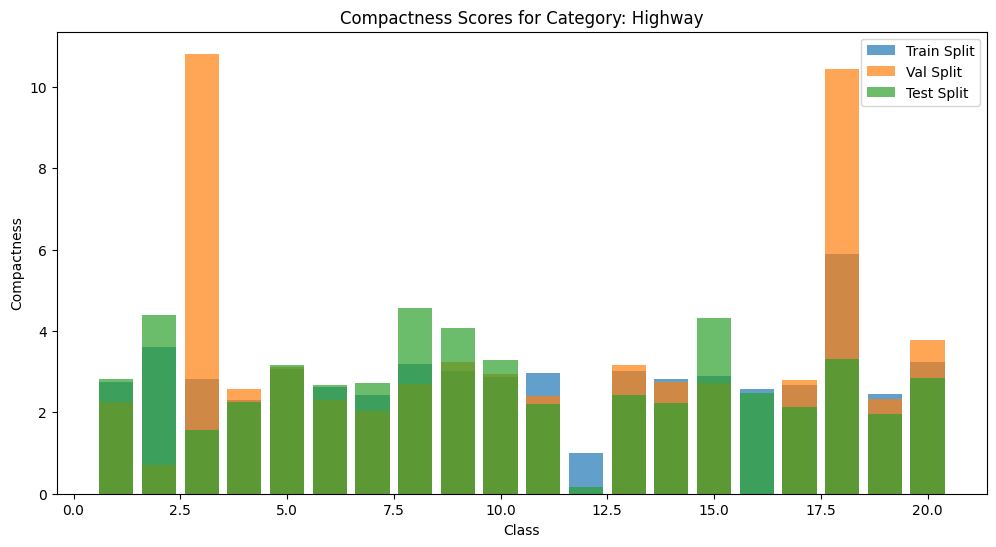

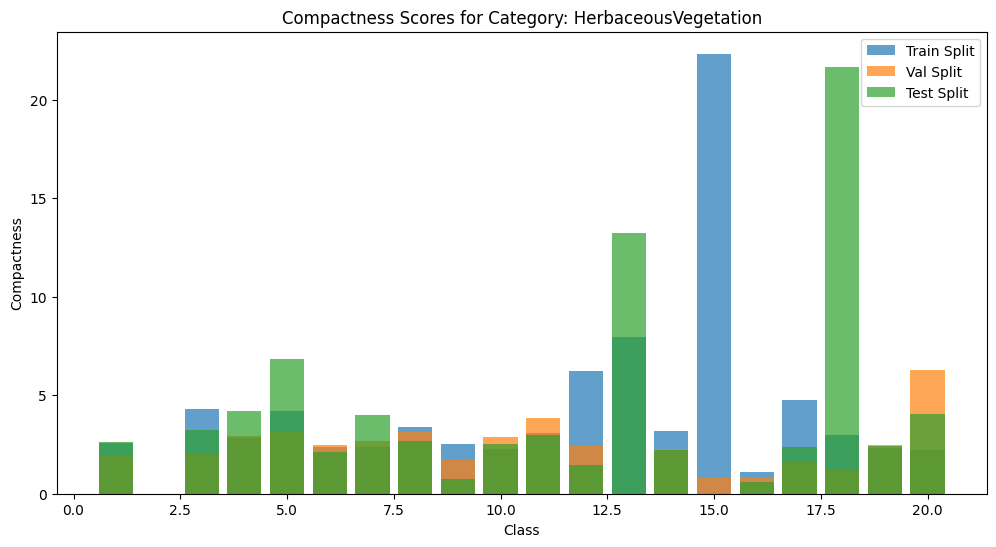

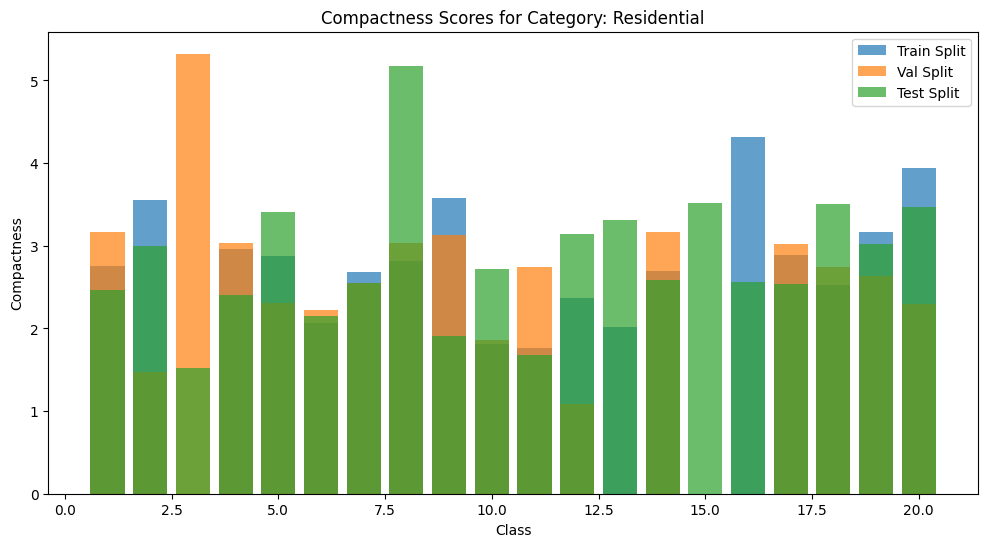

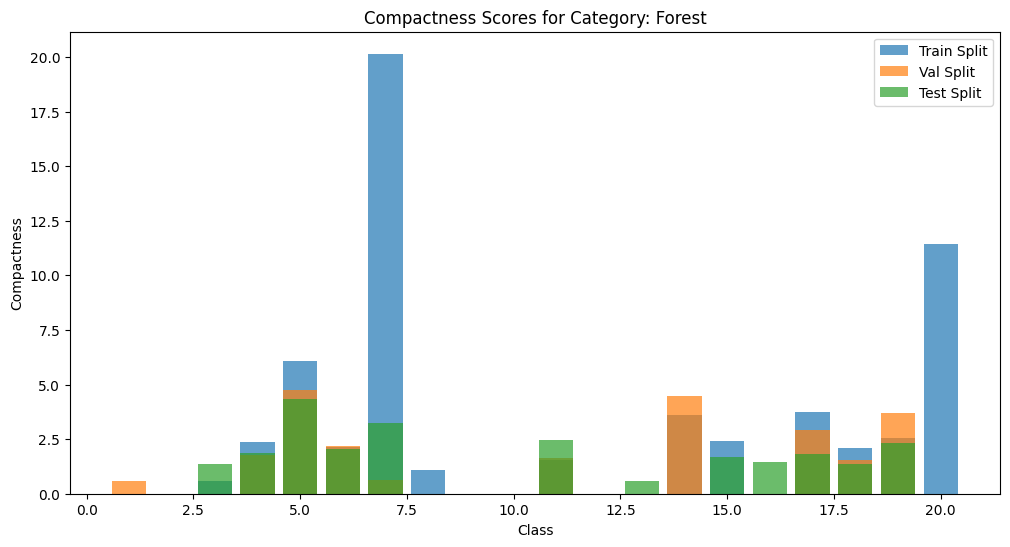

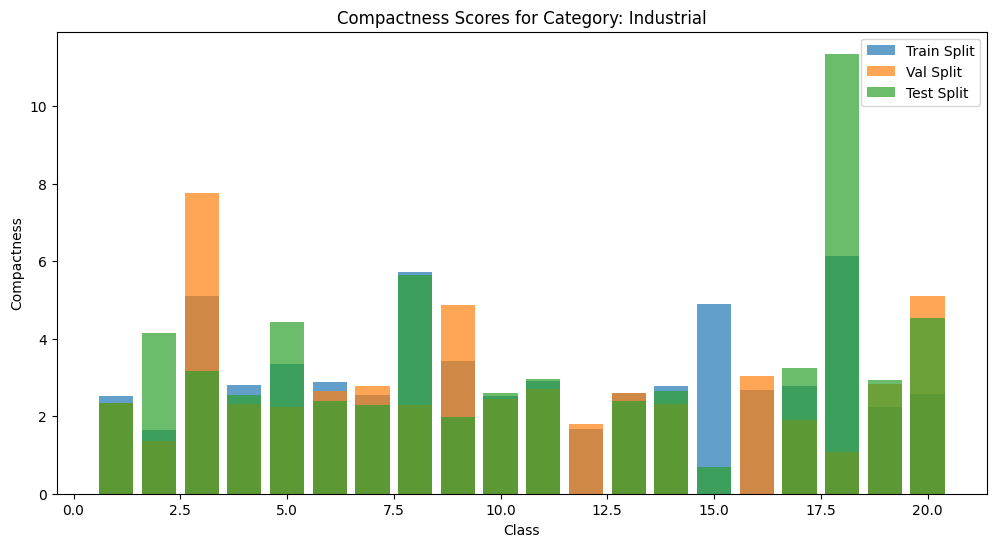

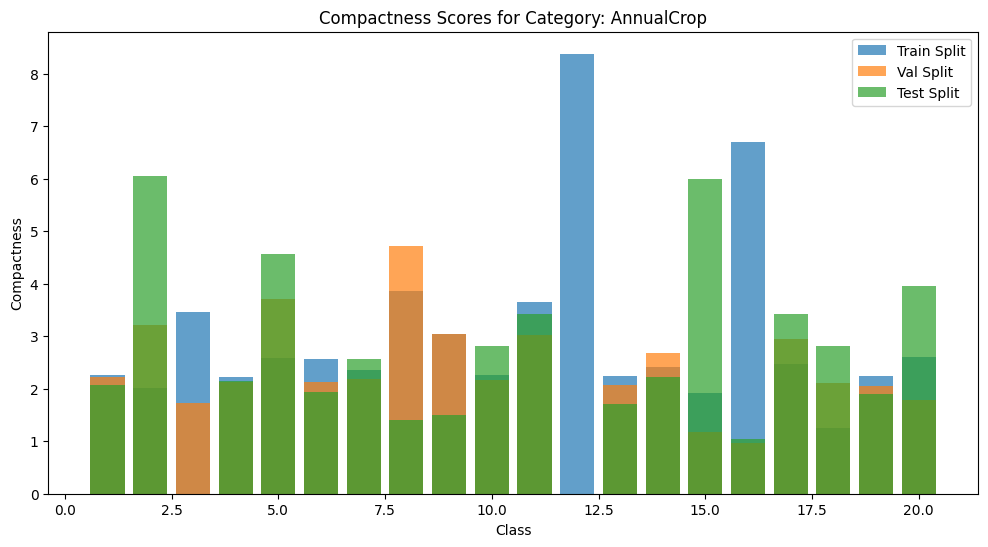

In [36]:
import matplotlib.pyplot as plt

def plot_compactness(compactness_results):
    for category, splits in compactness_results.items():
        plt.figure(figsize=(12, 6))
        for split, compactness in splits.items():
            classes = list(compactness.keys())
            scores = list(compactness.values())
            
            plt.bar(classes, scores, alpha=0.7, label=f"{split.capitalize()} Split")
        
        plt.title(f"Compactness Scores for Category: {category}")
        plt.xlabel("Class")
        plt.ylabel("Compactness")
        plt.legend()
        plt.show()

# Call the plotting function
plot_compactness(compactness_results)


In [37]:
"""
4. Region Count

    What it measures: Counts the number of contiguous regions for each class.
    Why it's useful: A high number of scattered regions could indicate noisy segmentation.
"""

import os
import numpy as np
import cv2
from skimage.measure import label
import logging

# Paths
categories = ["Forest", "Residential", "Highway", "AnnualCrop", "HerbaceousVegetation", "Industrial"]
splits = ["train", "val", "test"]
output_masks_dir = "../data/segmentation_masks"

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Function to calculate region counts
def calculate_region_counts(segmentation_mask):
    region_counts = {}
    unique_classes = np.unique(segmentation_mask)

    for cls in unique_classes:
        if cls == 0:
            continue  # Skip background class

        # Create a binary mask for the current class
        binary_mask = (segmentation_mask == cls).astype(np.uint8)

        # Count contiguous regions using connected component labeling
        labeled_mask = label(binary_mask, connectivity=2)
        region_counts[cls] = np.max(labeled_mask)  # Number of regions

    return region_counts

# Main function
results = {}
def analyze_region_counts():
    for category in categories:
        results[category] = {}
        for split in splits:
            logging.info(f"Analyzing region counts for {category} - {split}")
            split_dir = os.path.join(output_masks_dir, category, split)
            if not os.path.exists(split_dir):
                logging.warning(f"Directory not found: {split_dir}. Skipping.")
                continue

            region_count_summary = {}
            mask_files = [f for f in os.listdir(split_dir) if f.endswith(".npy")]

            for mask_file in mask_files:
                mask_path = os.path.join(split_dir, mask_file)
                segmentation_mask = np.load(mask_path)
                segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)

                # Calculate region counts
                region_counts = calculate_region_counts(segmentation_mask_class)

                # Aggregate results
                for cls, count in region_counts.items():
                    if cls not in region_count_summary:
                        region_count_summary[cls] = []
                    region_count_summary[cls].append(count)

            # Calculate average region count per class
            results[category][split] = {
                cls: np.mean(counts) for cls, counts in region_count_summary.items()
            }

            logging.info(f"Completed {category} - {split}")

    # Display results
    for category, splits_data in results.items():
        print(f"Category: {category}")
        for split, class_data in splits_data.items():
            print(f"  Split: {split}")
            for cls, avg_count in class_data.items():
                print(f"    Class {cls}: Average Region Count: {avg_count:.2f}")

if __name__ == "__main__":
    analyze_region_counts()


2024-12-24 00:06:05,830 - INFO - Analyzing region counts for Forest - train
2024-12-24 00:06:12,186 - INFO - Completed Forest - train
2024-12-24 00:06:12,187 - INFO - Analyzing region counts for Forest - val
2024-12-24 00:06:13,954 - INFO - Completed Forest - val
2024-12-24 00:06:13,955 - INFO - Analyzing region counts for Forest - test
2024-12-24 00:06:16,672 - INFO - Completed Forest - test
2024-12-24 00:06:16,673 - INFO - Analyzing region counts for Residential - train
2024-12-24 00:06:24,765 - INFO - Completed Residential - train
2024-12-24 00:06:24,766 - INFO - Analyzing region counts for Residential - val
2024-12-24 00:06:27,280 - INFO - Completed Residential - val
2024-12-24 00:06:27,281 - INFO - Analyzing region counts for Residential - test
2024-12-24 00:06:29,463 - INFO - Completed Residential - test
2024-12-24 00:06:29,463 - INFO - Analyzing region counts for Highway - train
2024-12-24 00:06:35,708 - INFO - Completed Highway - train
2024-12-24 00:06:35,709 - INFO - Analyzing

Category: Forest
  Split: train
    Class 6: Average Region Count: 10.04
    Class 19: Average Region Count: 8.36
    Class 17: Average Region Count: 4.70
    Class 4: Average Region Count: 6.72
    Class 5: Average Region Count: 3.00
    Class 18: Average Region Count: 15.67
    Class 15: Average Region Count: 2.00
    Class 14: Average Region Count: 2.00
    Class 11: Average Region Count: 6.73
    Class 16: Average Region Count: 1.00
    Class 7: Average Region Count: 2.00
    Class 3: Average Region Count: 3.00
    Class 8: Average Region Count: 4.00
    Class 20: Average Region Count: 6.00
  Split: val
    Class 6: Average Region Count: 10.65
    Class 19: Average Region Count: 9.12
    Class 4: Average Region Count: 6.57
    Class 5: Average Region Count: 1.50
    Class 17: Average Region Count: 7.50
    Class 18: Average Region Count: 13.50
    Class 11: Average Region Count: 7.25
    Class 1: Average Region Count: 4.00
    Class 7: Average Region Count: 4.50
    Class 14: Avera